<a href="https://colab.research.google.com/github/kimdonggyu2008/music_generation/blob/main/Drum_generation_cellular_automata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
from enum import Enum

import numpy as np
from music21 import *

In [ ]:

!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

!apt-get install xvfb

!sh -e /etc/init.d/x11-common start

import os
os.putenv('DISPLAY', ':99.0')

!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

Repository: 'deb https://ppa.launchpadcontent.net/mscore-ubuntu/mscore-stable/ubuntu/ jammy main'
Description:
~~~~~~~~~ MUSESCORE 2 RELEASES FOR UBUNTU 12.04 AND LATER ~~~~~~~~~
Note that Canonical doesn’t allow new builds for releases marked obsolete
(any nōn-LTS predating the previous LTS (currently 24.04 “noble”), and any LTS
older than 7 years, currently anything before 14.04 “trusty”). The packages
for those older releases here can no longer be updated but still work, within
limitations. Best to upgrade to a supported release of the operating system!

INSTALLING: (run these commands from the terminal)
  sudo add-apt-repository ppa:mscore-ubuntu/mscore-stable
  sudo apt-get update
  sudo apt-get install musescore

DO *NOT* USE THESE PPAs on Debian, only on Ubuntu!

‣‣‣ These packages are NOT suitable for ”KDE neon 18.04 (bionic)”!
‣ Use https://build.opensuse.org/project/show/home:mirabile:mscore instead.
⚠ KDE neon 18.04 was discontinued so those packages can no longer be updated

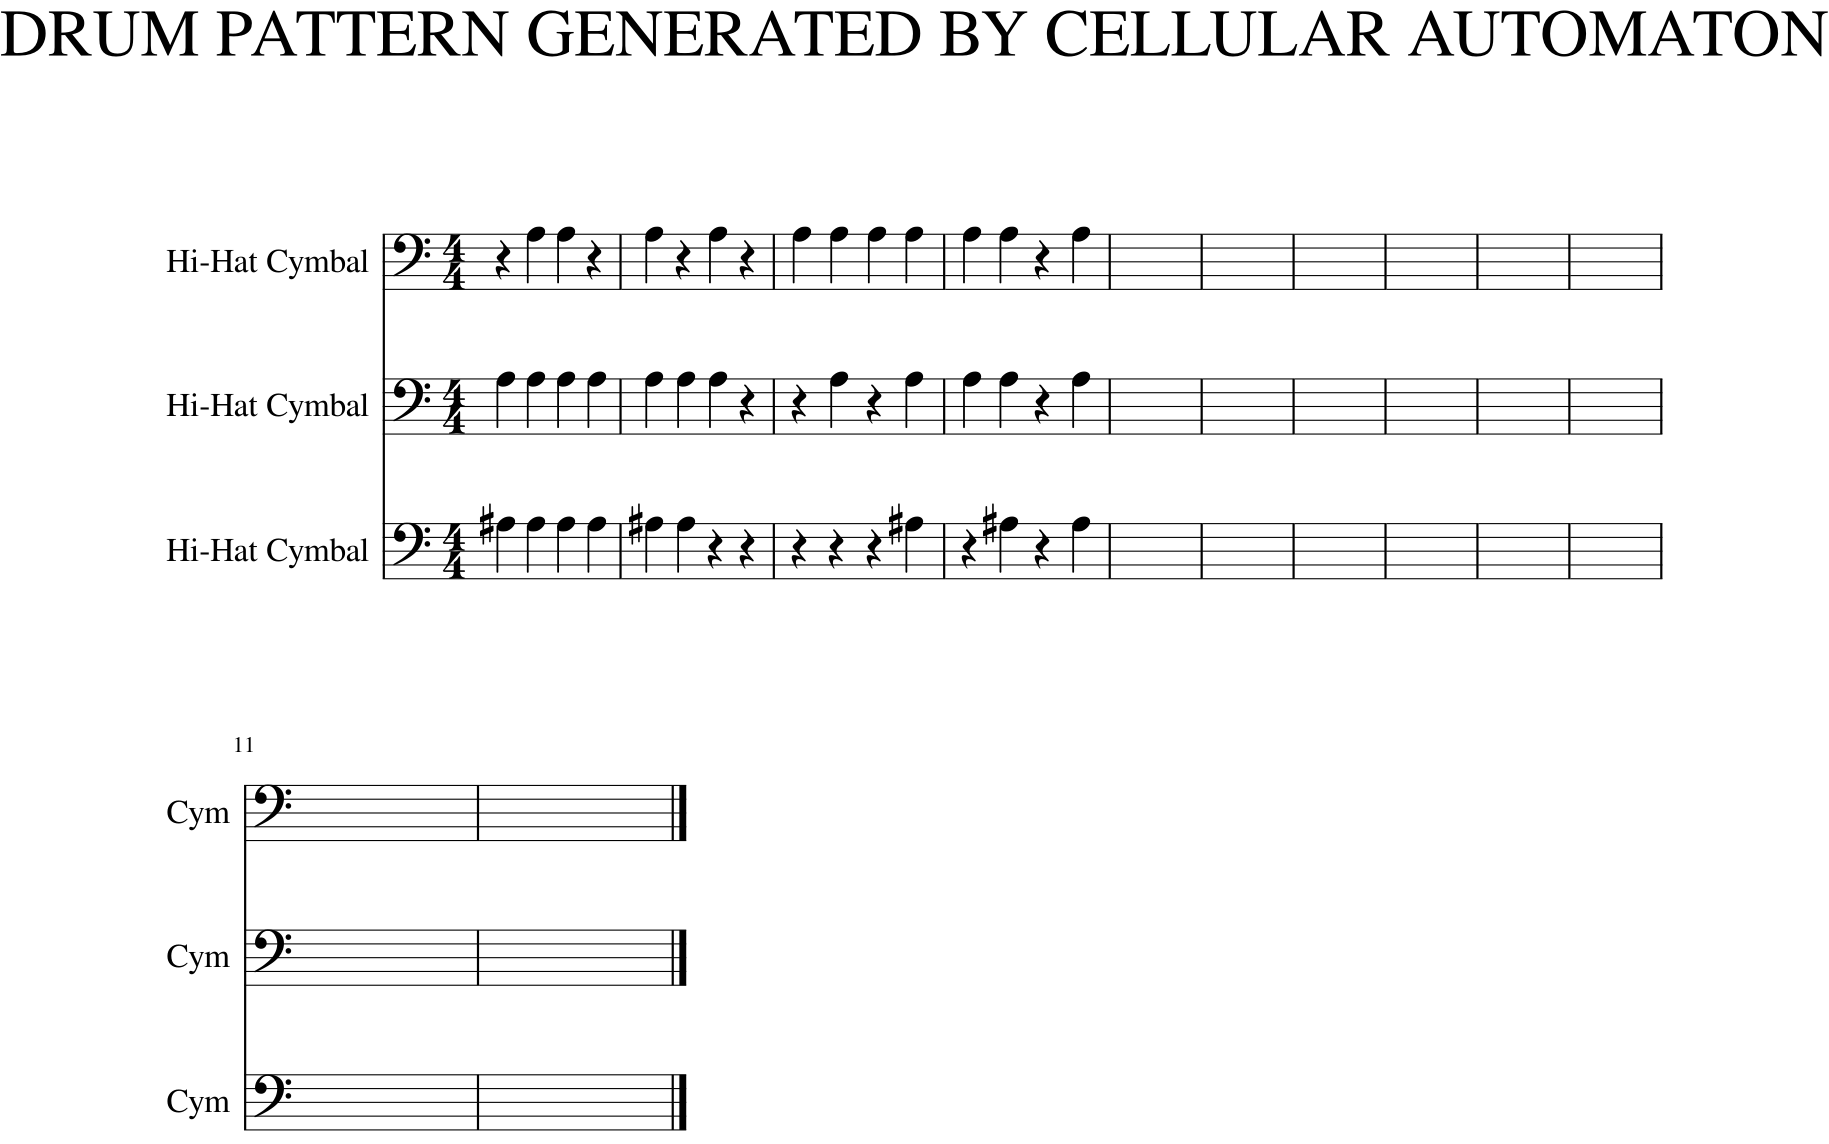

In [ ]:
class DrumInstruments(Enum): #각 악기에 대해 번호 부여
  KICK=0
  SNARE=1
  HIHAT=2
  #DrumInstruments.악기.value와 동일한 값을 가짐

class DrumStates(Enum): #각 악기가 가질 수 있는 상태 부여
  OFF=0
  ON=1

class CellularAutomatonDrumGenerator: #하이햇이 일정확률로 다른 소리를 냄
  HIHAT_ON_PROBABILITY=0.7
  MUTATION_PROBABILITY=0.1

  def __init__(self,pattern_length):
    self.pattern_length=pattern_length #박자 지정
    self.state=self._initialize_state(pattern_length) # 초기 상황 지정
    self._rules={ #4종류의 다른 규칙 지정
        "syncopation_resolution": self._apply_syncopation_resolution_rule, #당김음
        "filling_gaps": self._apply_filling_gaps_rule, #쉼표
        "accenting": self._apply_accenting_rule, #액센트
        "mutation": self._apply_mutation_rule, #어긋난 음
    }

  def step(self): #하나씩 진행함
    new_state=self.state.copy() #현재 상태를 복사함
    for position in range(self.pattern_length):
      new_state=self._apply_rules(position,new_state) #복사된 상태에 규칙을 적용해서 변경함
    self.state=new_state #현재 상태을 저장함

  def _initialize_state(self,pattern_length):
    number_of_instruments=len(DrumInstruments) #총 입력가능한 갯수
    return np.random.choice( #각 위치에 대해서 랜덤한 값을 부여함(0,1)
        [DrumStates.OFF.value,DrumStates.ON.value],
        size=(number_of_instruments,pattern_length),
    )

  def _apply_rules(self,position,new_state):
    for rule in self._rules.values(): #각 룰이 가지는 상태
      new_state=rule(position,new_state) #룰 적용
    return new_state

  def _apply_syncopation_resolution_rule(self,position,new_state): #당김음
    new_position=self._get_next_position(position) #바로 다음 위치

    if(
        self.state[DrumInstruments.HIHAT.value][position]
        ==DrumStates.ON.value
        and self.state[DrumInstruments.KICK.value][position]
        ==DrumStates.OFF.value
      ):
        new_state[DrumInstruments.KICK.value][
            new_position
            ]=DrumStates.ON.value
    return new_state

  def _get_next_position(self,position): #현재 마디가 끝나면 새로운 패턴으로 시작(pattern_length가 마디에 포함된 비트수)
    return (position+1)%self.pattern_length

  def _apply_filling_gaps_rule(self,position,new_state): #킥이 2박동안 나오지 않으면, 다음 박에 스네어 추가
    previous_position=self._get_previous_position(position)
    next_position=self._get_next_position(position)
    if(
        self.state[DrumInstruments.KICK.value][previous_position]#이전 위치에 킥이 없음
        == DrumStates.OFF.value
        and self.state[DrumInstruments.KICK.value][position]#현재 위치에도 킥이 없음
        == DrumStates.OFF.value
    ):
      new_state[DrumInstruments.SNARE.value][#다음 박에 스네어를 추가함
          next_position
      ]=DrumStates.ON.value

    if(
        self.state[DrumInstruments.SNARE.value][previous_position]#이전 위치에 스네어가 없음
        ==DrumStates.OFF.value
        and self.state[DrumInstruments.SNARE.value][position]#현재 위치에도 스네어가 없음
        ==DrumStates.OFF.value
    ):
      new_state[DrumInstruments.KICK.value][#다음 박에 킥을 추가함
          next_position
      ]=DrumStates.ON.value
    return new_state

  def _get_previous_position(self,position):
    if position>0: #시작지점인지 마지막 지점인지 구별
      return position-1 #마지막 지점인 경우, -1
    return self.pattern_length-1 시작 지점인 경우

  def _apply_accenting_rule(self,position,new_state): #액센트
    if(
        self.state[DrumInstruments.KICK.value][position]#킥이 존재하는 경우
        ==DrumStates.ON.value
        and self.state[DrumInstruments.SNARE.value][position]#스네어도 존재하는 경우
        ==DrumStates.ON.value
    ):
      if random.random()<self.HIHAT_ON_PROBABILITY:#확률에 따라서 하이햇 추가
        new_hihat_state=DrumStates.ON.value
      else:
        new_hihat_state=DrumStates.OFF.value #아니면 하이햇을 추가하지 않음
      new_state[DrumInstruments.HIHAT.value][position]=new_hihat_state

    return new_state

  def _apply_mutation_rule(self,position,new_state): #음역에서 벗어나는 경우, 엇박?
    if random.random()<self.MUTATION_PROBABILITY:
      instrument_choice=random.choice(
          [
              DrumInstruments.KICK,
              DrumInstruments.SNARE,
              DrumInstruments.HIHAT,
          ]
      )
      new_instruments_state=random.choice(
          [DrumStates.ON.value,DrumStates.OFF.value]
      )
      new_state[instrument_choice.value][position]=new_instruments_state
    return new_state

class DrumPatternMusic21Converter:
  MIDI_PITCHES = {
        DrumInstruments.KICK: 36,
        DrumInstruments.SNARE: 38,
        DrumInstruments.HIHAT: 42,
    }
  def to_music21_score(self,state):
    score=stream.Score()
    score.metadata=metadata.Metadata(
        title="DRUM PATTERN GENERATED BY CELLULAR AUTOMATON"
    )
    pattern_length=len(state[0])
    for drum_instrument in DrumInstruments:
      part=self._instrument_to_music21_part(
          drum_instrument,state,pattern_length
      )
      score.append(part)
    return score

  def _instrument_to_music21_part( #악보로 출력
      self,drum_instrument,state,pattern_length
  ):
    part=stream.Part()
    part.insert(0,instrument.HiHatCymbal())

    for position in range(pattern_length):
      if(
          state[drum_instrument.value][position]==1
      ):
        note_pitch=self._get_midi_pitch_for_instrument(
            drum_instrument
        )
        drum_note=note.Note()
        drum_note.pitch.midi=note_pitch
        drum_note.duration.quarterLength=1
        part.append(drum_note)
      else:
        part.append(note.Rest(quarterLength=1))
    return part

  def _get_midi_pitch_for_instrument(self,drum_instrument):
    return self.MIDI_PITCHES.get(
        drum_instrument,0
    )

def main():
  drum_generator=CellularAutomatonDrumGenerator(pattern_length=16)
  music_converter=DrumPatternMusic21Converter()

  for _ in range(8): #8박 넣기
    drum_generator.step() #하나씩 진행
  score=music_converter.to_music21_score(drum_generator.state) #악보 생성

  score.show()

if __name__=="__main__":
  main()